In [923]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
np.random.seed(42)

In [924]:
# amount of people per hours where python 0 is 9:00, 1 (python) is 10:00 ... until 22:00
# restourant closes at 23:00 so, last guest can come only before 22:00 from 9
amount_of_hours = 22 - 9
# my plan to generate lognormal distribution witn max at 19:00 it's 3 hours before close
guests_per_hours = {}
increase_coef = 13
for i in range(amount_of_hours -2):
    guests_per_hours[i+9] = np.random.randint(increase_coef - 2, increase_coef + 2)
    increase_coef =+ np.random.randint(increase_coef - 1 , increase_coef + 15)
# at 19:00 was max, usually guests seat longer and untill the end
for i in range(amount_of_hours - 2, amount_of_hours + 1):
    increase_coef =+ np.random.randint(increase_coef - 40 , increase_coef + 2)
    guests_per_hours[i+9] = increase_coef
# 7 days and increasing coeficients for every day, for Monday is 1, for Tuesday is 1.17...  
coef = list(map(lambda x: round(x,2),np.linspace(1,2,7)))

start_date_non = '2023-06-01 00:00:00'
start_date_non = datetime.strptime(start_date_non, '%Y-%m-%d %H:%M:%S')

# I have range for 1 hour, and it depends on amount of people how much dates I will have in 1 hour interval
list_dates = []
# i is my delta in days
for i in range(30):
    # go via dict of people
     for key, guests_per_hour in guests_per_hours.items():
        # start date as defolt, just add a bit chaos, to start not from 9:00 but from 9:00 - 9:02
        start_time = start_date_non + timedelta(days=i,hours = key, minutes=np.random.randint(0,2))
        # if I have end time as xx:00 then I will start from yy:00 and it will be double date
        end_time = start_time + timedelta(minutes= np.random.randint(54,58)) 
        steps = int(guests_per_hour * coef[start_time.weekday()]) # coef depends on day of week
        steps = np.random.randint(steps - 5, steps + 5) # to add a bit chaos +-5 people per hour from average
        time_intervals = pd.date_range(start=start_time, end=end_time, periods=steps)
        list_dates.extend(time_intervals)
         

Text(0.5, 1.0, 'Amount of guest via hours')

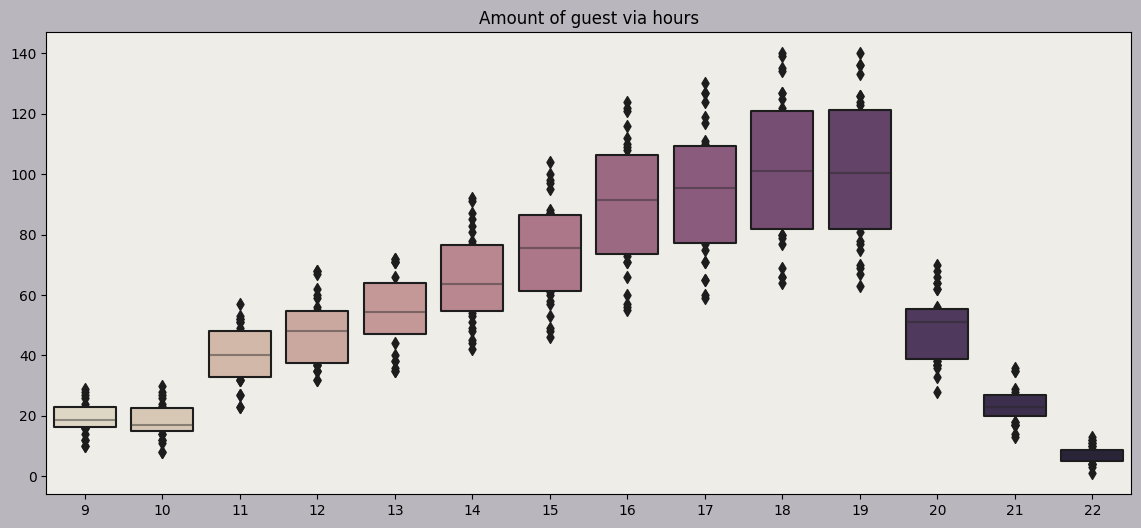

In [925]:
df = pd.DataFrame({'date':list_dates})
df['date'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d %H:%M:%S'))
df['day'], df['hour'] = df['date'].dt.dayofweek, df['date'].dt.hour
df['date_only'] = df['date'].dt.date
# to solve reverse task:) to see how many people per hour via days of week
dict_of_hours = {} # key is hour value is sum of people
for i in range(df['hour'].nunique()):
    i = i + 9
    temp_list = [] # all values for exact intervals
    for j in df['date_only'].unique(): # for every day, not only for days of week
        orders_amount = len(df[(df['date_only'] == j) & (df['hour'] == i)]) # choosing filtered dataset and counting his lenght
        temp_list.append(orders_amount)
    dict_of_hours[i] = temp_list # key is time, values are amount of people for specific day

# to visualize my grouped data
tem_df = pd.DataFrame(dict_of_hours)
fig, ax = plt.subplots(1,1,figsize=(14, 6), facecolor = '#B9B7BD')
sns.boxenplot(tem_df, ax = ax, palette= 'ch:s=-.2,r=.6' )
ax.set_facecolor("#EEEDE7")
ax.set_title('Amount of guest via hours')

In [926]:
df_income = pd.DataFrame(df['date'])

# generating amount of people from 1-4
df_income['amount_of_people'] = 1
df_income['amount_of_people'] = df_income['amount_of_people'].apply(lambda x: np.random.randint(x,5))
# I set low price of average to transform easier later
df_income['average_money'] = 10 # EUR
df_income['average_money'] = df_income['average_money'].apply(lambda x: np.random.uniform(x, x*1.7)).apply(lambda x: round(x,2))
df_income['total_money'] = df_income['average_money'] * df_income['amount_of_people']
# let's say we have 27% of price is self cost and to calculate our clean income
df_income['clean_income'] = (df_income['total_money'] * 0.73).apply(lambda x: round(x,2))

In [932]:
# to calculate my average clean income per every guest
clean_money_av = round((df_income['clean_income']/df_income['amount_of_people']).mean(), 2)
# to calculate average peoples for interesting hour
averega_per_hours = {}
for key,values in dict_of_hours.items():
    # to calculate people/hour
    averega_per_hours[key] = round(3600/round(np.mean(values))) # I got 1 guest per X seconds

# creating dataframe to see better
xt = pd.DataFrame(list(averega_per_hours.items()), columns=['hour', 'guests'])
xt['1_guest_per'] = xt['guests'].apply(lambda x: '{} min {} sec'.format(x//60, x%60))
xt = xt[['hour', '1_guest_per']]
xt['hour'] = xt['hour'].apply(lambda x: f'{x}:00')
xt.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
hour,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00
1_guest_per,3 min 9 sec,3 min 20 sec,1 min 30 sec,1 min 15 sec,1 min 7 sec,0 min 55 sec,0 min 49 sec,0 min 40 sec,0 min 38 sec,0 min 35 sec,0 min 36 sec,1 min 13 sec,2 min 37 sec,8 min 34 sec
